# 03. モデル評価指標 (Model Evaluation Metrics)

## 概要
機械学習モデルの性能を正しく評価する方法を学びます。

## 学習目標
- 分類問題の評価指標を理解できる
- 回帰問題の評価指標を理解できる
- 混同行列とROC曲線を作成できる
- クロスバリデーションを実行できる
- 学習曲線を分析できる

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, auc,
    mean_squared_error, mean_absolute_error, r2_score
)

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

## 1. 分類問題の評価指標

### 基本的な指標

分類問題では、予測がどれだけ正確かを測る必要があります。

**主な評価指標:**

1. **正解率（Accuracy）**
   - 全予測のうち、正しく分類した割合
   - 式: (TP + TN) / (TP + TN + FP + FN)
   - データが不均衡だと誤解を招く

2. **適合率（Precision）**
   - 陽性と予測したうち、実際に陽性だった割合
   - 式: TP / (TP + FP)
   - 偽陽性を減らしたい場合に重視

3. **再現率（Recall）**
   - 実際の陽性のうち、正しく予測できた割合
   - 式: TP / (TP + FN)
   - 偽陰性を減らしたい場合に重視

4. **F1スコア**
   - PrecisionとRecallの調和平均
   - 式: 2 × (Precision × Recall) / (Precision + Recall)
   - バランスの取れた指標

In [2]:
# 分類データ生成
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.7, 0.3],  # 不均衡データ
    random_state=42
)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# モデル学習
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# 評価指標の計算
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("分類評価指標:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

print(f"\nクラス分布（テスト）: {np.bincount(y_test)}")

分類評価指標:
  Accuracy:  0.8500
  Precision: 0.7719
  Recall:    0.7213
  F1 Score:  0.7458

クラス分布（テスト）: [139  61]


## 2. 混同行列（Confusion Matrix）

### 混同行列とは

予測と実際のクラスの関係を表にしたものです。

```
                予測
          Negative  Positive
実際 Neg     TN        FP
     Pos     FN        TP
```

- **TP (True Positive)**: 正しく陽性と予測
- **TN (True Negative)**: 正しく陰性と予測
- **FP (False Positive)**: 間違って陽性と予測（第1種の誤り）
- **FN (False Negative)**: 間違って陰性と予測（第2種の誤り）

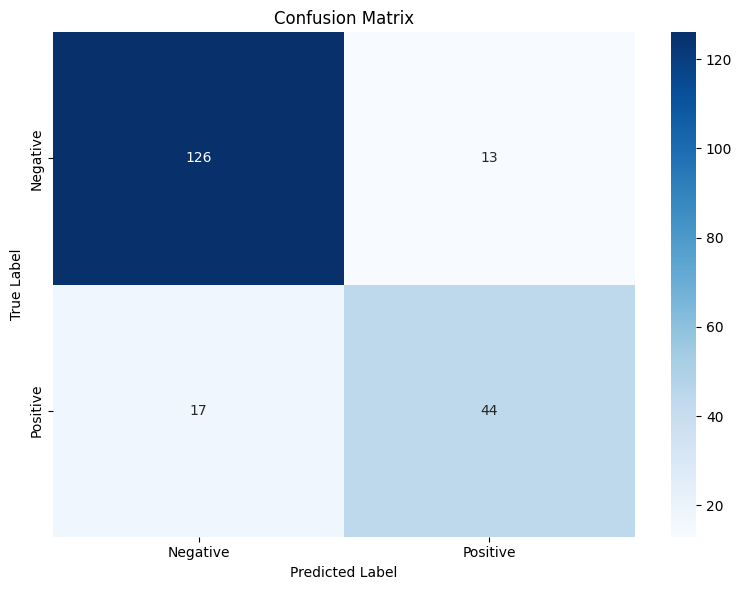

混同行列:
[[126  13]
 [ 17  44]]

True Negatives:  126
False Positives: 13
False Negatives: 17
True Positives:  44


In [3]:
# 混同行列の計算と可視化
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("混同行列:")
print(cm)
print(f"\nTrue Negatives:  {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")

In [4]:
# 詳細な分類レポート
print("\n詳細な分類レポート:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


詳細な分類レポート:
              precision    recall  f1-score   support

     Class 0       0.88      0.91      0.89       139
     Class 1       0.77      0.72      0.75        61

    accuracy                           0.85       200
   macro avg       0.83      0.81      0.82       200
weighted avg       0.85      0.85      0.85       200



## 3. ROC曲線とAUC

### ROC曲線とは

**ROC (Receiver Operating Characteristic) 曲線**は、分類器の性能を可視化する方法です。

- X軸: 偽陽性率（False Positive Rate） = FP / (FP + TN)
- Y軸: 真陽性率（True Positive Rate） = TP / (TP + FN)

### AUC (Area Under the Curve)

ROC曲線の下の面積です。

- **AUC = 1.0**: 完璧な分類器
- **AUC = 0.5**: ランダムな分類器
- **AUC < 0.5**: ランダムより悪い

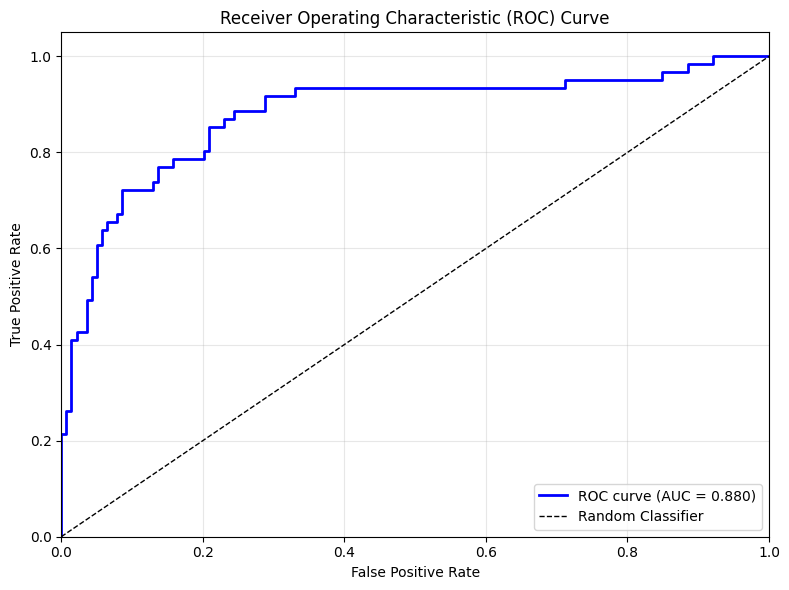

AUC Score: 0.8803


In [5]:
# ROC曲線の計算
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

## 4. 回帰問題の評価指標

### 主な評価指標

回帰問題では、予測値と実際の値の誤差を測定します。

1. **平均二乗誤差（MSE: Mean Squared Error）**
   - 式: Σ(y_true - y_pred)² / n
   - 大きな誤差に敏感
   - 単位が元のデータの二乗

2. **平均二乗平方根誤差（RMSE: Root Mean Squared Error）**
   - 式: √MSE
   - 元のデータと同じ単位
   - 解釈しやすい

3. **平均絶対誤差（MAE: Mean Absolute Error）**
   - 式: Σ|y_true - y_pred| / n
   - 外れ値に頑健

4. **決定係数（R²: R-squared）**
   - 式: 1 - (SS_res / SS_tot)
   - 0〜1の範囲（負の値も可能）
   - 1に近いほど良い

In [6]:
# 回帰データ生成
X_reg, y_reg = make_regression(
    n_samples=1000,
    n_features=10,
    noise=20,
    random_state=42
)

# データ分割
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# モデル学習
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

# 予測
y_pred_reg = reg_model.predict(X_test_reg)

# 評価指標の計算
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("回帰評価指標:")
print(f"  MSE:  {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R²:   {r2:.4f}")

回帰評価指標:
  MSE:  380.4766
  RMSE: 19.5058
  MAE:  15.5467
  R²:   0.9774


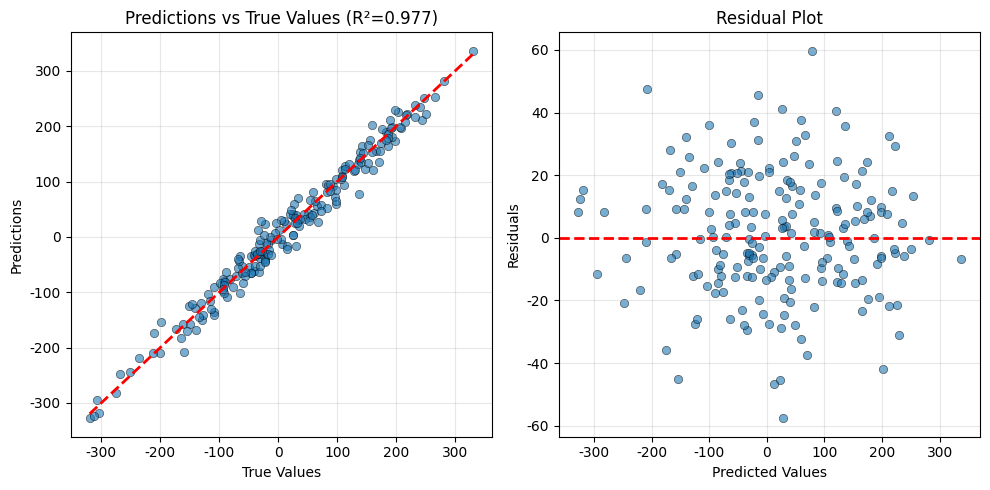

In [7]:
# 予測値 vs 実測値のプロット
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values (R²={r2:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test_reg - y_pred_reg
plt.scatter(y_pred_reg, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. クロスバリデーション

### クロスバリデーションとは

データを複数の分割（フォールド）に分け、それぞれを順番にテストデータとして使用する手法です。

**利点:**
- より信頼性の高い評価
- データの使用効率が良い
- 過学習の検出

### k-Fold Cross Validation

データをk個に分割し、k回の訓練・評価を行います。

In [8]:
from sklearn.model_selection import cross_validate

# 複数の指標でクロスバリデーション
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = cross_validate(
    model, X, y, cv=5, scoring=scoring, return_train_score=True
)

print("5-Fold Cross Validation Results:")
print("="*50)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}:")
    print(f"  Train: {train_scores.mean():.4f} (+/- {train_scores.std():.4f})")
    print(f"  Test:  {test_scores.mean():.4f} (+/- {test_scores.std():.4f})")
    print()

5-Fold Cross Validation Results:
Accuracy:
  Train: 0.8525 (+/- 0.0034)
  Test:  0.8480 (+/- 0.0242)

Precision:
  Train: 0.7775 (+/- 0.0022)
  Test:  0.7746 (+/- 0.0331)

Recall:
  Train: 0.7212 (+/- 0.0151)
  Test:  0.7071 (+/- 0.0995)

F1:
  Train: 0.7482 (+/- 0.0083)
  Test:  0.7357 (+/- 0.0525)



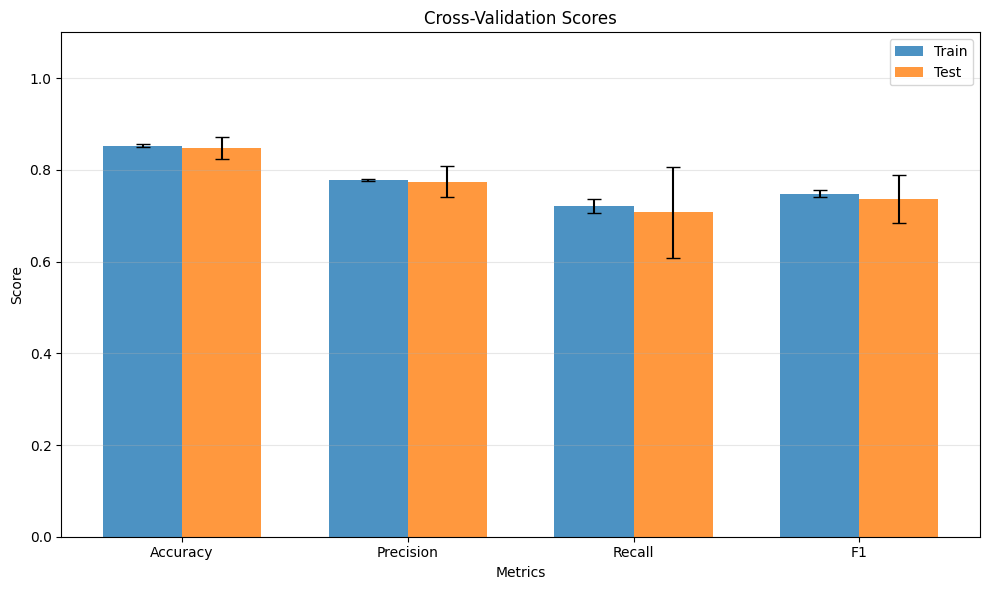

In [9]:
# クロスバリデーションスコアの可視化
metrics = ['accuracy', 'precision', 'recall', 'f1']
train_means = [cv_results[f'train_{m}'].mean() for m in metrics]
test_means = [cv_results[f'test_{m}'].mean() for m in metrics]
train_stds = [cv_results[f'train_{m}'].std() for m in metrics]
test_stds = [cv_results[f'test_{m}'].std() for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_means, width, yerr=train_stds, 
        label='Train', alpha=0.8, capsize=5)
plt.bar(x + width/2, test_means, width, yerr=test_stds, 
        label='Test', alpha=0.8, capsize=5)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Cross-Validation Scores')
plt.xticks(x, [m.capitalize() for m in metrics])
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. 学習曲線

### 学習曲線とは

訓練データサイズを変えながら、モデルの性能がどう変化するかを示す曲線です。

**学習曲線から分かること:**
- 過学習の有無
- データ量が十分か
- モデルの複雑さは適切か

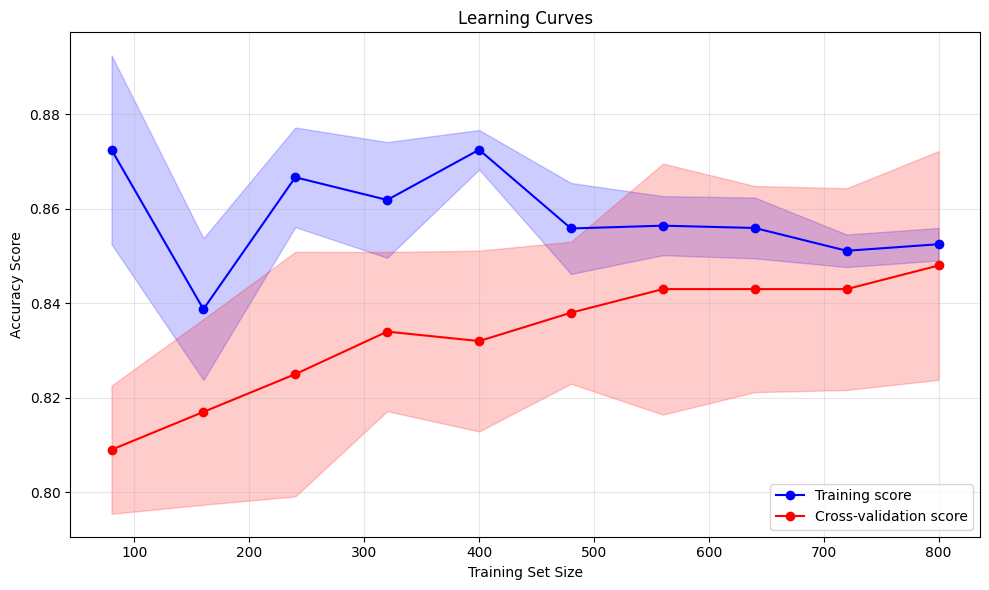

学習曲線の解釈:
  ✓ 良好な学習状態です


In [10]:
# 学習曲線の計算
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# 平均と標準偏差の計算
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 可視化
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='b', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='b')
plt.plot(train_sizes, test_mean, 'o-', color='r', label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                 alpha=0.2, color='r')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("学習曲線の解釈:")
if train_mean[-1] - test_mean[-1] > 0.1:
    print("  ⚠ 過学習の可能性があります")
    print("  対策: 正則化の強化、モデルの簡略化、データの追加")
elif test_mean[-1] < 0.7:
    print("  ⚠ 学習不足の可能性があります")
    print("  対策: モデルの複雑化、特徴量の追加、学習時間の延長")
else:
    print("  ✓ 良好な学習状態です")

## 7. まとめ

### 本ノートブックで学んだこと

1. **分類評価指標**
   - Accuracy、Precision、Recall、F1スコア
   - それぞれの使い分け

2. **混同行列**
   - TP、TN、FP、FNの理解
   - 誤り のタイプの分析

3. **ROC曲線とAUC**
   - 分類器の性能可視化
   - 閾値の調整

4. **回帰評価指標**
   - MSE、RMSE、MAE、R²
   - 残差分析

5. **クロスバリデーション**
   - k-Fold CV
   - より信頼性の高い評価

6. **学習曲線**
   - 過学習/学習不足の検出
   - データ量の十分性の確認

### 評価指標の選び方

**分類問題:**
- バランスの取れたデータ → Accuracy
- 不均衡データ → F1、AUC
- 偽陽性を減らしたい → Precision
- 偽陰性を減らしたい → Recall

**回帰問題:**
- 一般的な用途 → RMSE
- 外れ値に頑健 → MAE
- モデルの説明力 → R²

### 次のステップ

- Notebook 04以降で具体的なモデルを学ぶ
- 実際のデータセットで評価を実践
- より高度な評価手法を探求